In [24]:
import json
import csv
import os
import matplotlib.pyplot as plt
import random

from datetime import datetime
from tqdm import tqdm
import numpy as np

from zootools.data_parsing import Parser, Reducer
from zootools.data_output import HDFOutput

In [2]:
# classification_fname = os.path.join(os.getenv('MUOND'), 'zooniverse', 'MH1', 'aggregated', 'muon-hunter-aggregated.json')
# with open(classification_fname, 'r') as file:
#     data = json.load(file)
    
# print('Number of subjects: %d' % len(data['subjects']))
# print(data.keys())
# counts = [len(c) for c in data['counts']['T1']]


Number of subjects: 137515
dict_keys(['majority', 'fraction', 'tasks', 'subjects', 'values'])


KeyError: 'counts'

Found tarballs with image files. Presumably these are the image files that were uploaded to the Zooniverse, but there is not 100% overlap. There are 137,516 subjects in the subject export, but these tarballs only contain 58,370 images. Not all of these image filenames show up in the subject export.

In [25]:
directory = '/mnt/storage/science_data/muon_data/images/mh1'
subjects_csv = '/mnt/storage/science_data/muon_data/zooniverse/MH1/muon-hunter-subjects.csv'
with open(subjects_csv, 'r') as file:
    reader = csv.DictReader(file)
    subjects = {}
    for row in tqdm(reader):
        meta = json.loads(row['metadata'])
        fname = None
        for value in meta.values():
            if type(value) is str and 'jpeg' in value:
                fname = value
                break
        subjects[fname] = row['subject_id']


fname_data = []
for dir, _, filenames in os.walk(directory):
    if dir != '.':
        for filename in filenames:
            if os.path.splitext(filename)[1] == '.jpeg':
                fname_data.append(filename)
fname_data = set(fname_data)
subject_data = set(subjects.keys())

print('filenames:', len(fname_data))
print('filenames also in subject export:', len(fname_data & subject_data))
print('filenames not in subject export:', len(fname_data - subject_data))
# print(len(fname_data ^ subject_data))


137515it [00:03, 38357.01it/s]


filenames: 58370
filenames also in subject export: 19422
filenames not in subject export: 38948


Will see if I can find renamed versions of the missing filenames in the subject export. Will parse the run,evt,tel in each filename and look for these matches

In [26]:
from muon.swap.muon_metadata import SubjectID
subjects = {}
subject_count = 0
for subject, (run, evt, tel) in SubjectID.get_data(subjects_csv):
    item = (run, evt)
    if item not in subjects:
        subjects[item] = []
    subjects[item].append(subject)
    subject_count += 1
    
date_format = '%Y-%m-%d %H:%M:%S %Z'
subject_metadata = {}
with open(subjects_csv, 'r') as file:
    reader = csv.DictReader(file)
    for row in tqdm(reader):
        subject_metadata[int(row['subject_id'])] = {
            'metadata': json.loads(row['metadata']),
            'url': json.loads(row['locations'])['0'],
            'subject_set': int(row['subject_set_id']),
            'retired_at': datetime.strptime(row['retired_at'], date_format)}
# subject_data = SubjectID.collect_data(subjects_csv)
# subject_count = len(subjects)
# subjects = {(value['run'], value['evt']): subject for subject, value in subjects.items()}
# display(subject_data)

images = {}
image_count = 0
for dir, folder, filenames in os.walk(directory):
    if dir != '.':
        for filename in tqdm(filenames):
            if os.path.splitext(filename)[1] == '.jpeg':
                run, evt, tel = SubjectID.parse_fname(filename)
                image_count += 1
                item = (run, evt)
                if item not in images:
                    images[item] = []
                images[item].append((dir, filename))

subject_set = set(subjects.keys())
image_set = set(images.keys())

print(subject_count - len(subject_set))
print(image_count - len(image_set))


diff = image_set - subject_set
print(len(diff))
print(diff)

display([images[i] for i in diff])

137515it [00:09, 14529.73it/s]
100%|██████████| 38947/38947 [00:00<00:00, 49909.44it/s]

43653
1807
10
{(78597, 301258), (78597, 312715), (78597, 308689), (78573, 10052), (78597, 290039), (78597, 307983), (78597, 303706), (78597, 291552), (78597, 306999), (78597, 303427)}


[[('/mnt/storage/science_data/muon_data/images/mh1/muon_hunter_non_muon_images_no_cleaning',
   '78597_non_muon_evt301258_tel3.jpeg')],
 [('/mnt/storage/science_data/muon_data/images/mh1/muon_hunter_non_muon_images_no_cleaning',
   '78597_non_muon_evt312715_tel2.jpeg')],
 [('/mnt/storage/science_data/muon_data/images/mh1/muon_hunter_non_muon_images_no_cleaning',
   '78597_non_muon_evt308689_tel2.jpeg')],
 [('/mnt/storage/science_data/muon_data/images/mh1/muon_hunter_ambiguous_images_clean',
   '78573_ambiguous_evt10052_tel1.jpeg')],
 [('/mnt/storage/science_data/muon_data/images/mh1/muon_hunter_non_muon_images_no_cleaning',
   '78597_non_muon_evt290039_tel0.jpeg')],
 [('/mnt/storage/science_data/muon_data/images/mh1/muon_hunter_non_muon_images_no_cleaning',
   '78597_non_muon_evt307983_tel0.jpeg')],
 [('/mnt/storage/science_data/muon_data/images/mh1/muon_hunter_non_muon_images_no_cleaning',
   '78597_non_muon_evt303706_tel2.jpeg')],
 [('/mnt/storage/science_data/muon_data/images/mh1/mu

Number of occurences of each (run, event) pair, and the distribution in the image filenames and subjects uploaded to panoptes

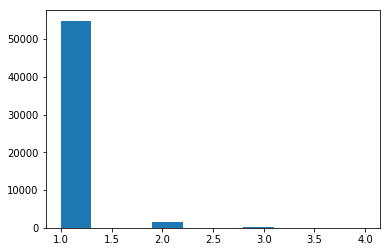

0 0
1 54844
2 1635
3 80
4 4


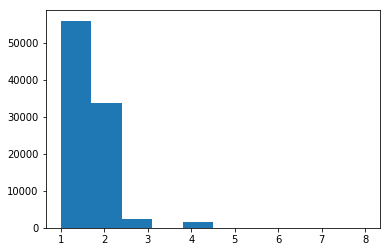

0 0
1 56031
2 33799
3 2407
4 1514


In [63]:
# Statistics on how many duplicated images there are
import numpy as np

c = np.array([len(images[i]) for i in images])
plt.hist(c)
plt.show()

for i in range(5):
    print(i, np.sum(c==i))

c = np.array([len(subjects[i]) for i in subjects])
plt.hist(c)
plt.show()

for i in range(5):
    print(i, np.sum(c==i))

(47511, 0)
[3353054]
run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


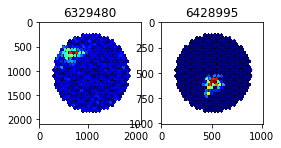

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


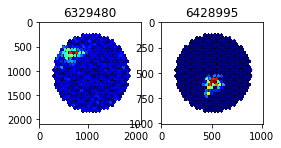

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


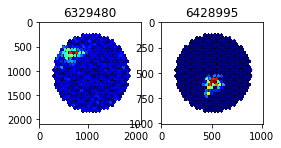

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


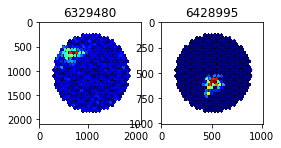

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


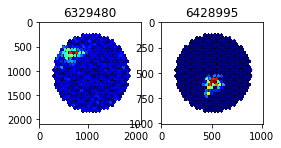

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


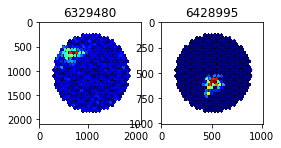

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


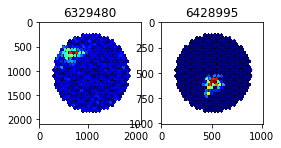

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


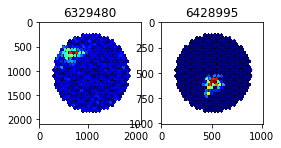

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


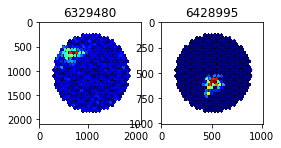

run,evt (81783, 16300)
{'id': 32102, 'image': '81783_ambiguous_evt16300_tel1.jpeg'} 8447 2017-03-19 16:29:21
{'Clean': 'Yes', 'Filename': '81783hide_label_evt16300_tel1.jpeg'} 7872 2017-03-14 00:28:52


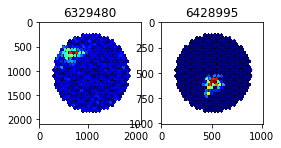

In [31]:
from PIL import Image
import requests
from io import BytesIO

def plot_mh1_subjects(event_list):
    for item in event_list:
        print('run,evt', item)
        figsize = (2*len(subjects[item]), 2)
        fig = plt.figure(figsize=figsize)
        for j, subject in enumerate(subjects[item]):
            ax = fig.add_subplot(1, len(subjects[item]), j+1)
            ax.set_title(subject)

            url = subject_metadata[subject]['url']
            image = Image.open(BytesIO(requests.get(url).content))
            ax.imshow(image)
            print(subject_metadata[subject]['metadata'], subject_metadata[subject]['subject_set'], subject_metadata[subject]['retired_at'])
        plt.show()

plot_list = []
print(list(subjects.keys())[0])
print(list(subjects.values())[0])
for event in subjects.keys():
    if len(subjects[event]) > 2:
        plot_list.append(item)
random.shuffle(plot_list)
plot_mh1_subjects(plot_list[:10])
# i=0
# iter_s = list(subjects.keys())
# random.shuffle(iter_s)
# for item in iter_s:
#     if len(subjects[item]) > 2:
#         print('run,evt', item)
#         fig = plt.figure(figsize=(10,10))
#         for j, subject in enumerate(subjects[item]):
#             ax = fig.add_subplot(1, len(subjects[item]), j+1)
#             ax.set_title(subject)

#             url = subject_metadata[subject]['url']
#             image = Image.open(BytesIO(requests.get(url).content))
#             ax.imshow(image)
#             print(subject_metadata[subject]['metadata'], subject_metadata[subject]['subject_set'])
#         plt.show()
#         i += 1
#     if i>30:
#         break

In [30]:
data = []
for event in subjects:
    if len(subjects[event]) > 2:
        for subject in subjects[event]:
            data.append(subject_metadata[subject]['subject_set'])
data = np.array(data)
print(np.unique(data, return_counts=True))

data = []
for event in subjects:
    if len(subjects[event]):
        for subject in subjects[event]:
            data.append(subject_metadata[subject]['subject_set'])
data = np.array(data)
print(np.unique(data, return_counts=True))

        

(array([7872, 8434, 8446, 8447, 8450, 8451]), array([4157,   96,    7, 3329, 1710, 4587]))
(array([5749, 5750, 5751, 7872, 8434, 8446, 8447, 8450, 8451]), array([ 1322,   700,   300, 38092, 13211,  6211, 38834, 28844, 10001]))


70712it [00:00, 248723.10it/s]


run,evt (81634, 94460)
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt94460_tel0.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt94460_tel3.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt94460_tel0.jpeg'} 8450


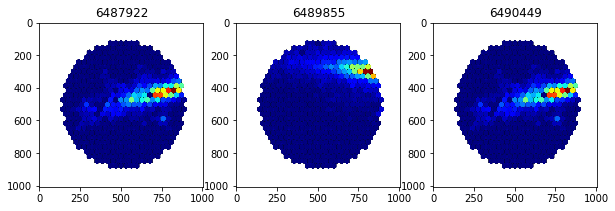

[(81634, 94460, 0)]


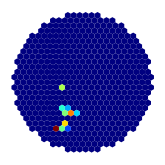

run,evt (85061, 5590)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5590_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5590_tel2.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5590_tel3.jpeg'} 8451


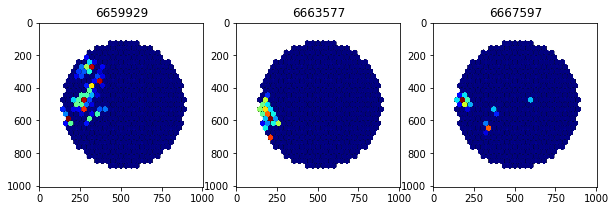

[(85061, 5590, 1)]


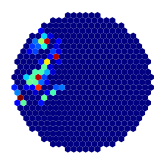

run,evt (85061, 609)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt609_tel2.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt609_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt609_tel1.jpeg'} 8451


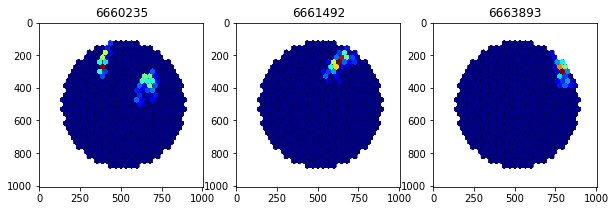

[(85061, 609, 1)]


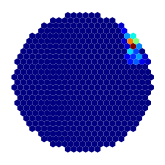

run,evt (81634, 31898)
{'id': 27497, 'image': '81634_ambiguous_evt31898_tel1.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '81634hide_label_evt31898_tel1.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt31898_tel2.jpeg'} 8450


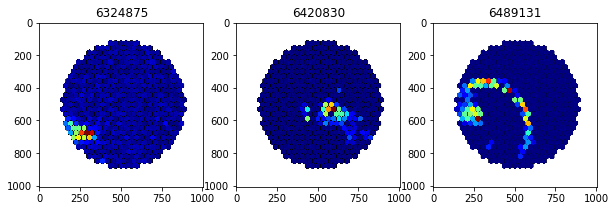

[(81634, 31898, 1)]


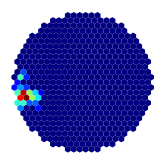

run,evt (78596, 90713)
{'id': 9844, 'image': '78596_ambiguous_evt90713_tel1.jpeg'} 8447
{'id': 9845, 'image': '78596_ambiguous_evt90713_tel2.jpeg'} 8447
{'Filename': '78596hide_label_evt90713_tel1.jpeg'} 7872
{'Filename': '78596hide_label_evt90713_tel2.jpeg'} 7872


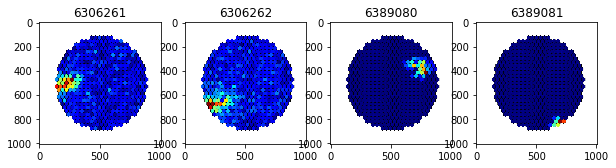

[(78596, 90713, 1)]


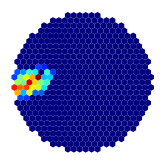

run,evt (78597, 275384)
{'id': 10770, 'image': '78597_ambiguous_evt275384_tel1.jpeg'} 8447
{'id': 10771, 'image': '78597_ambiguous_evt275384_tel2.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '78597hide_label_evt275384_tel1.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '78597hide_label_evt275384_tel2.jpeg'} 7872


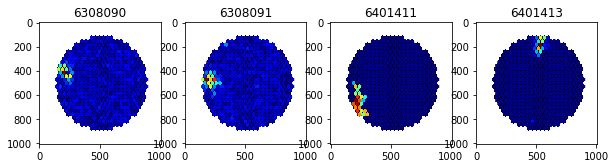

[(78597, 275384, 1)]


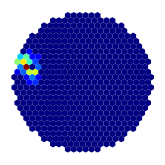

run,evt (85061, 8423)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt8423_tel2.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt8423_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt8423_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt8423_tel0.jpeg'} 8451


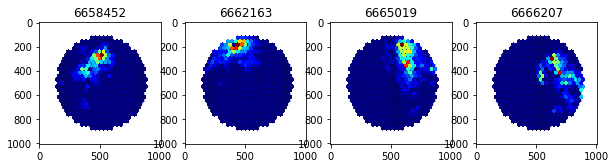

[(85061, 8423, 0)]


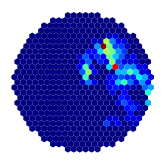

run,evt (85061, 5022)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5022_tel2.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5022_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5022_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5022_tel0.jpeg'} 8451


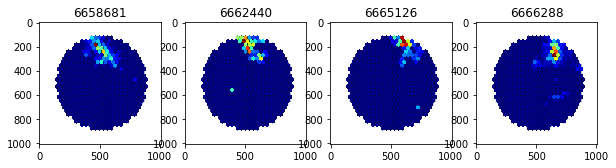

[(85061, 5022, 0)]


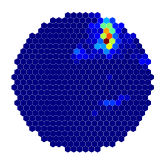

run,evt (85061, 553)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt553_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt553_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt553_tel2.jpeg'} 8451


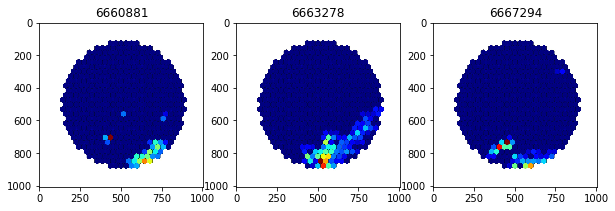

[(85061, 553, 1)]


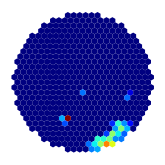

run,evt (85061, 6502)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt6502_tel0.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt6502_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt6502_tel2.jpeg'} 8451


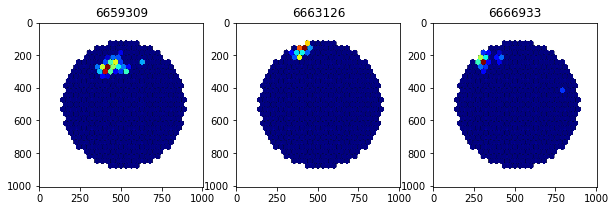

[(85061, 6502, 0)]


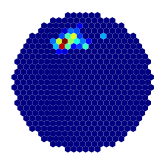

run,evt (78596, 484302)
{'id': 8931, 'image': '78596_ambiguous_evt484302_tel1.jpeg'} 8447
{'id': 8932, 'image': '78596_ambiguous_evt484302_tel3.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '78596hide_label_evt484302_tel1.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '78596hide_label_evt484302_tel3.jpeg'} 7872


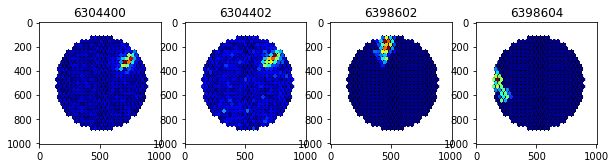

[(78596, 484302, 1)]


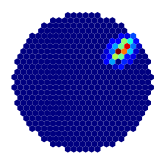

run,evt (85061, 6565)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt6565_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt6565_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt6565_tel0.jpeg'} 8451


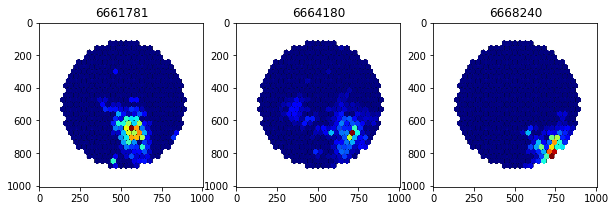

[(85061, 6565, 0)]


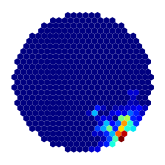

run,evt (81634, 20623)
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt20623_tel1.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt20623_tel1.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt20623_tel2.jpeg'} 8450


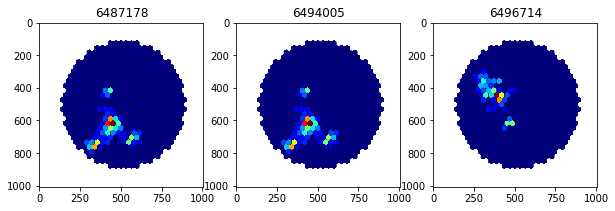

[(81634, 20623, 1)]


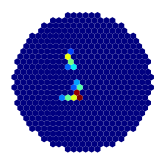

run,evt (81635, 210677)
{'id': 30940, 'image': '81635_ambiguous_evt210677_tel0.jpeg'} 8447
{'id': 30941, 'image': '81635_ambiguous_evt210677_tel3.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '81635hide_label_evt210677_tel0.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '81635hide_label_evt210677_tel3.jpeg'} 7872


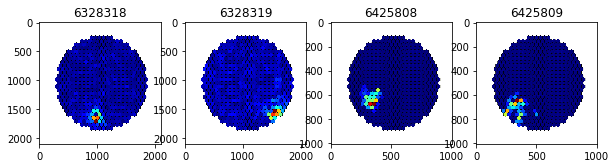

[(81635, 210677, 0)]


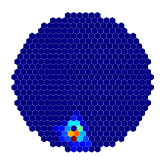

run,evt (81783, 196299)
{'id': 32328, 'image': '81783_ambiguous_evt196299_tel2.jpeg'} 8447
{'id': 32329, 'image': '81783_ambiguous_evt196299_tel3.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '81783hide_label_evt196299_tel2.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '81783hide_label_evt196299_tel3.jpeg'} 7872


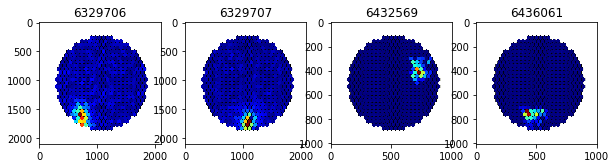

[(81783, 196299, 2)]


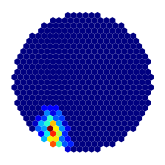

run,evt (85061, 3357)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt3357_tel0.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt3357_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt3357_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt3357_tel2.jpeg'} 8451


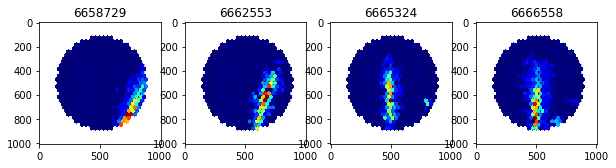

[(85061, 3357, 0)]


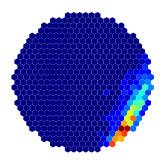

run,evt (81635, 76591)
{'id': 31529, 'image': '81635_ambiguous_evt76591_tel0.jpeg'} 8447
{'id': 31530, 'image': '81635_ambiguous_evt76591_tel1.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '81635hide_label_evt76591_tel0.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '81635hide_label_evt76591_tel1.jpeg'} 7872


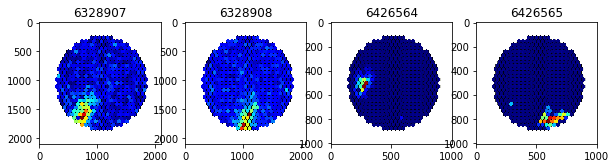

[(81635, 76591, 0)]


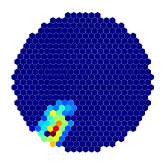

run,evt (78596, 296126)
{'id': 7953, 'image': '78596_ambiguous_evt296126_tel1.jpeg'} 8447
{'id': 7954, 'image': '78596_ambiguous_evt296126_tel3.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '78596hide_label_evt296126_tel1.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '78596hide_label_evt296126_tel3.jpeg'} 7872


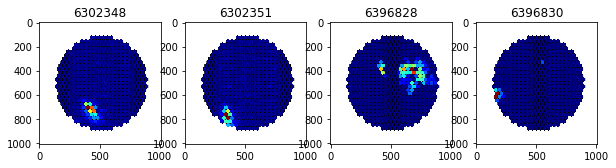

[(78596, 296126, 1)]


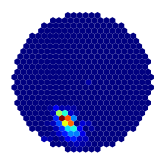

run,evt (81783, 477157)
{'id': 34102, 'image': '81783_ambiguous_evt477157_tel2.jpeg'} 8447
{'id': 34103, 'image': '81783_ambiguous_evt477157_tel3.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '81783hide_label_evt477157_tel2.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '81783hide_label_evt477157_tel3.jpeg'} 7872


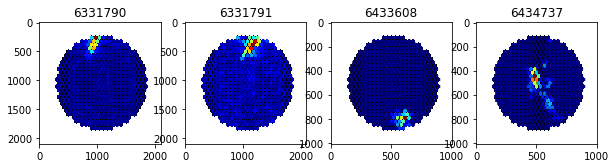

[(81783, 477157, 2)]


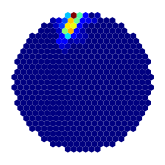

run,evt (81634, 73615)
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt73615_tel3.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt73615_tel3.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt73615_tel1.jpeg'} 8450


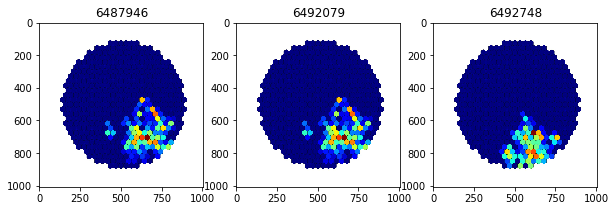

[(81634, 73615, 1)]


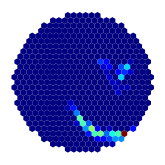

run,evt (78573, 727034)
{'id': 3156, 'image': '78573_ambiguous_evt727034_tel0.jpeg'} 8447
{'id': 3157, 'image': '78573_ambiguous_evt727034_tel1.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '78573hide_label_evt727034_tel0.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '78573hide_label_evt727034_tel1.jpeg'} 7872


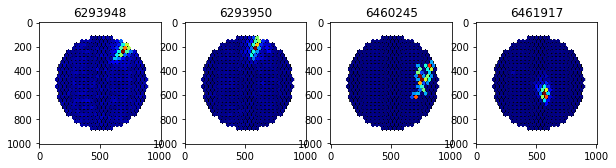

[(78573, 727034, 0)]


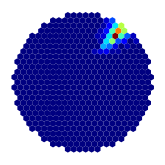

run,evt (85061, 5085)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5085_tel0.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5085_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5085_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt5085_tel2.jpeg'} 8451


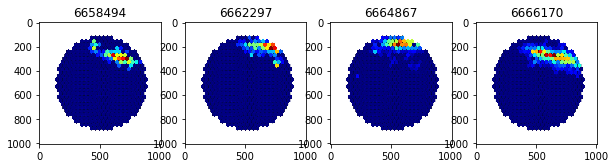

[(85061, 5085, 0)]


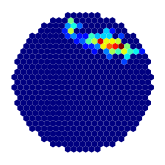

run,evt (81496, 121477)
{'id': 22295, 'image': '81496_ambiguous_evt121477_tel1.jpeg'} 8447
{'id': 22296, 'image': '81496_ambiguous_evt121477_tel2.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '81496hide_label_evt121477_tel1.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '81496hide_label_evt121477_tel2.jpeg'} 7872


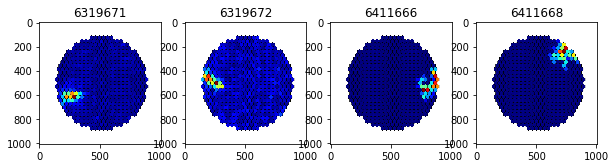

[(81496, 121477, 1)]


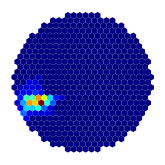

run,evt (78598, 221881)
{'id': 13383, 'image': '78598_ambiguous_evt221881_tel1.jpeg'} 8447
{'id': 13384, 'image': '78598_ambiguous_evt221881_tel2.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '78598hide_label_evt221881_tel1.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '78598hide_label_evt221881_tel2.jpeg'} 7872


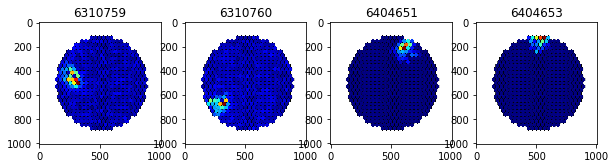

[(78598, 221881, 1)]


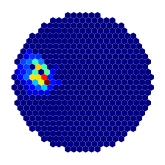

run,evt (85061, 2028)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt2028_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt2028_tel2.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt2028_tel0.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt2028_tel1.jpeg'} 8451


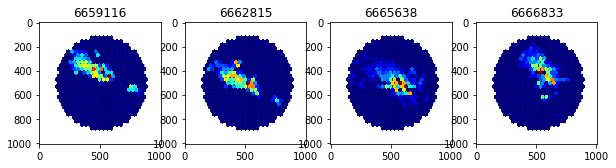

[(85061, 2028, 0)]


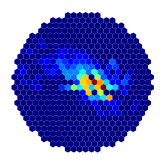

run,evt (81634, 438819)
{'id': 28315, 'image': '81634_ambiguous_evt438819_tel1.jpeg'} 8447
{'id': 28316, 'image': '81634_ambiguous_evt438819_tel2.jpeg'} 8447
{'Clean': 'Yes', 'Filename': '81634hide_label_evt438819_tel1.jpeg'} 7872
{'Clean': 'Yes', 'Filename': '81634hide_label_evt438819_tel2.jpeg'} 7872


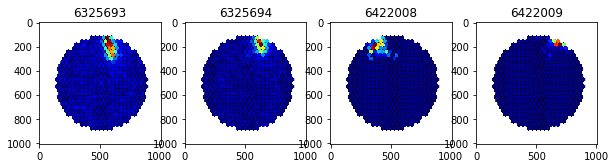

[(81634, 438819, 1)]


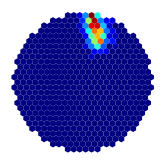

run,evt (85061, 4702)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt4702_tel0.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt4702_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt4702_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt4702_tel2.jpeg'} 8451


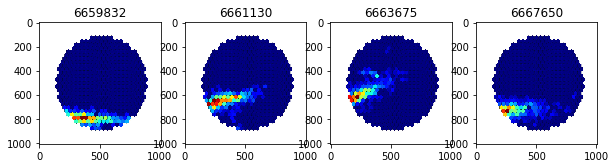

[(85061, 4702, 0)]


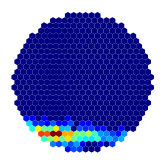

run,evt (85061, 8631)
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt8631_tel1.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt8631_tel3.jpeg'} 8451
{'Clean': 'Yes', 'Filename': '85061_hide_label_evt8631_tel2.jpeg'} 8451


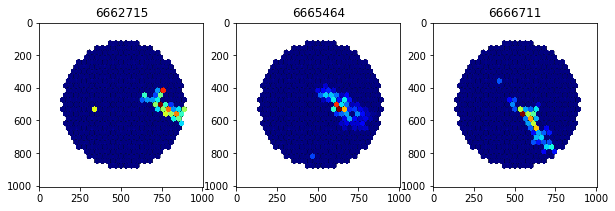

[(85061, 8631, 1)]


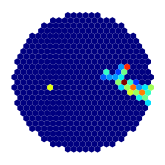

run,evt (81634, 71190)
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt71190_tel2.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt71190_tel3.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt71190_tel0.jpeg'} 8450


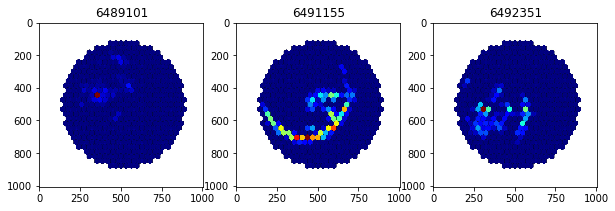

[(81634, 71190, 0)]


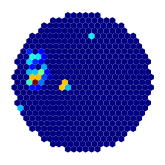

run,evt (81634, 63114)
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt63114_tel2.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt63114_tel2.jpeg'} 8450
{'Clean': 'Yes', 'Filename': '81634_hide_label_evt63114_tel2.jpeg'} 8450


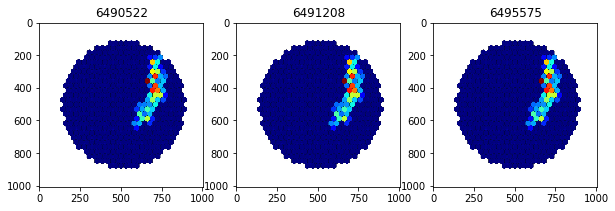

[(81634, 63114, 2)]


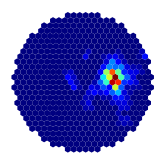

In [26]:
subjects_fname = '/mnt/storage/science_data/muon_data/subjects/subjects.pkl'
import pickle
from muon.utils.subjects import Subjects
with open(subjects_fname, 'rb') as file:
    mh2_subjects = pickle.load(file)

mh2_subjects_mapping = {}
for subject in tqdm(mh2_subjects.iter()):
    run, event, _ = subject.event
    event = run, event
    if event in subjects and len(subjects[event]) > 2:
        if event not in mh2_subjects_mapping:
            mh2_subjects_mapping[event] = []
        mh2_subjects_mapping[event].append(subject.id)

plot_list = list(mh2_subjects_mapping.keys())
random.shuffle(plot_list)
for event in plot_list[:30]:
    subset = mh2_subjects.subset(mh2_subjects_mapping[event])
    plot_mh1_subjects([event])
    print([subject.event for subject in subset.iter()])
    subset.plot_subjects(w=len(subset))
    plt.show()
    


In [45]:
subjects_fname = '/mnt/storage/science_data/muon_data/subjects/subjects.pkl'
import pickle
from muon.utils.subjects import Subjects
with open(subjects_fname, 'rb') as file:
    mh2_subjects = pickle.load(file)

mh2_subject_sets = []
for subject in tqdm(mh2_subjects.iter()):
    run, event, _ = subject.event
    event = run, event
    if event in subjects:
        for s in subjects[event]:
            mh2_subject_sets.append(subject_metadata[s]['subject_set'])
print(np.unique(mh2_subject_sets, return_counts=True))

70712it [00:00, 179803.69it/s]


(array([7872, 8434, 8446, 8447, 8450, 8451]), array([29787,    42,  5579, 35108, 28844, 10001]))


70712it [00:01, 36475.81it/s]


run,evt (78598, 590104)
{'id': 15288, 'image': '78598_ambiguous_evt590104_tel2.jpeg'} 8447 2017-03-28 09:27:48
{'Clean': 'Yes', 'Filename': '78598hide_label_evt590104_tel2.jpeg'} 7872 2017-04-14 14:36:20


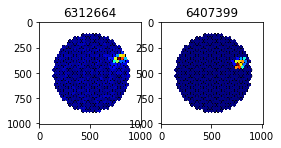

[(78598, 590104, 2)]


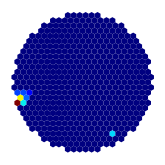

run,evt (78598, 380694)
{'id': 14218, 'image': '78598_ambiguous_evt380694_tel3.jpeg'} 8447 2017-03-16 17:42:46
{'Clean': 'Yes', 'Filename': '78598hide_label_evt380694_tel3.jpeg'} 7872 2017-03-21 22:29:27


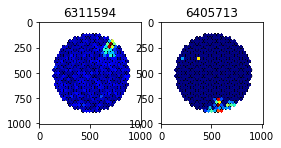

[(78598, 380694, 3)]


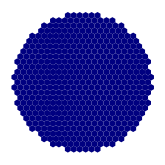

run,evt (81496, 219523)
{'id': 22987, 'image': '81496_ambiguous_evt219523_tel3.jpeg'} 8447 2017-03-05 05:58:08
{'Clean': 'Yes', 'Filename': '81496hide_label_evt219523_tel3.jpeg'} 7872 2017-03-03 19:43:15


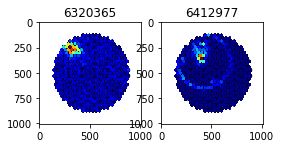

[(81496, 219523, 3)]


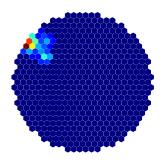

run,evt (78576, 171761)
{'id': 3927, 'image': '78576_ambiguous_evt171761_tel0.jpeg'} 8447 2017-03-10 11:48:32
{'Clean': 'Yes', 'Filename': '78576hide_label_evt171761_tel0.jpeg'} 7872 2017-03-14 19:04:17


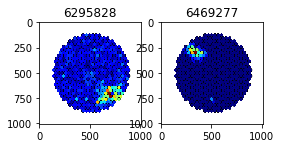

[(78576, 171761, 0)]


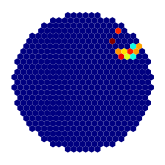

run,evt (81496, 494168)
{'id': 24884, 'image': '81496_ambiguous_evt494168_tel0.jpeg'} 8447 2017-03-14 20:24:12
{'id': 24885, 'image': '81496_ambiguous_evt494168_tel1.jpeg'} 8447 2017-03-15 10:28:30
{'Clean': 'Yes', 'Filename': '81496hide_label_evt494168_tel0.jpeg'} 7872 2017-03-07 01:29:47
{'Clean': 'Yes', 'Filename': '81496hide_label_evt494168_tel1.jpeg'} 7872 2017-04-12 19:08:46


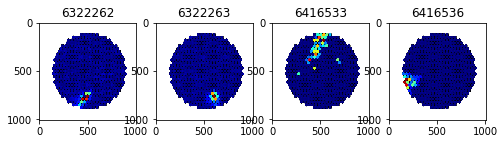

[(81496, 494168, 0)]


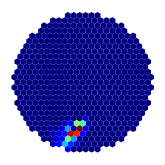

run,evt (81635, 142119)
{'id': 30472, 'image': '81635_ambiguous_evt142119_tel1.jpeg'} 8447 2017-03-05 21:32:43
{'Clean': 'Yes', 'Filename': '81635hide_label_evt142119_tel1.jpeg'} 7872 2017-03-04 17:16:37


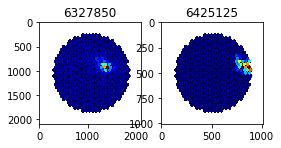

[(81635, 142119, 1)]


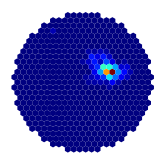

run,evt (78596, 146775)
{'id': 7176, 'image': '78596_ambiguous_evt146775_tel3.jpeg'} 8447 2017-03-09 16:50:37
{'Filename': '78596hide_label_evt146775_tel3.jpeg'} 7872 2017-04-16 14:59:23


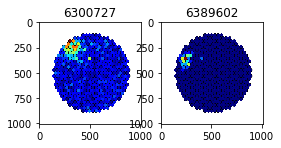

[(78596, 146775, 3)]


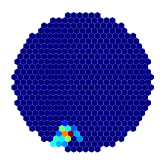

run,evt (78597, 340986)
{'id': 11094, 'image': '78597_ambiguous_evt340986_tel2.jpeg'} 8447 2017-03-14 14:43:38
{'Clean': 'Yes', 'Filename': '78597hide_label_evt340986_tel2.jpeg'} 7872 2017-03-24 22:20:53


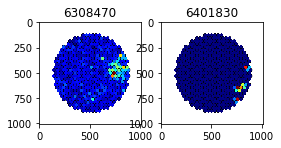

[(78597, 340986, 2)]


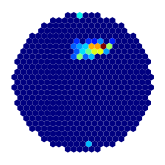

run,evt (78597, 457947)
{'id': 11686, 'image': '78597_ambiguous_evt457947_tel2.jpeg'} 8447 2017-03-04 03:22:46
{'Clean': 'Yes', 'Filename': '78597hide_label_evt457947_tel2.jpeg'} 7872 2017-03-31 20:19:55


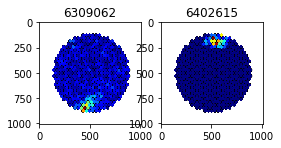

[(78597, 457947, 2)]


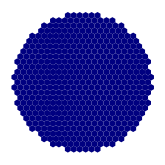

run,evt (81634, 127239)
{'id': 26173, 'image': '81634_ambiguous_evt127239_tel2.jpeg'} 8447 2017-03-14 16:20:45
{'Clean': 'Yes', 'Filename': '81634hide_label_evt127239_tel2.jpeg'} 7872 2017-04-08 20:44:54


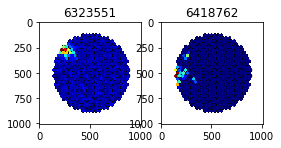

[(81634, 127239, 2)]


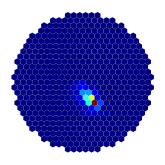

run,evt (81784, 325777)
{'id': 36800, 'image': '81784_ambiguous_evt325777_tel2.jpeg'} 8447 2017-03-06 17:11:59
{'Clean': 'Yes', 'Filename': '81784hide_label_evt325777_tel2.jpeg'} 7872 2017-04-03 14:37:13


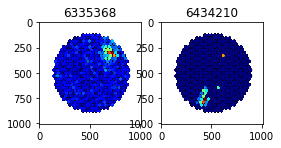

[(81784, 325777, 2)]


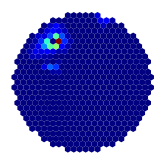

run,evt (81496, 286374)
{'id': 23406, 'image': '81496_ambiguous_evt286374_tel1.jpeg'} 8447 2017-03-07 17:17:15
{'Clean': 'Yes', 'Filename': '81496hide_label_evt286374_tel1.jpeg'} 7872 2017-03-15 00:56:33


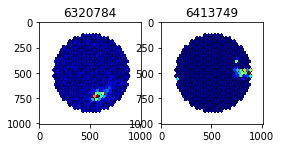

[(81496, 286374, 1)]


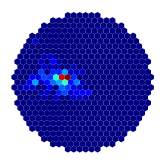

run,evt (81496, 555227)
{'id': 25314, 'image': '81496_ambiguous_evt555227_tel2.jpeg'} 8447 2017-03-05 17:09:41
{'Clean': 'Yes', 'Filename': '81496hide_label_evt555227_tel2.jpeg'} 7872 2017-04-01 17:19:03


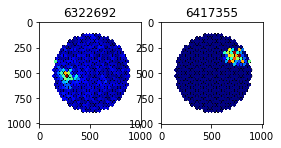

[(81496, 555227, 2)]


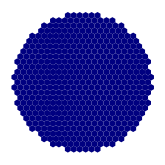

run,evt (81783, 534757)
{'id': 34454, 'image': '81783_ambiguous_evt534757_tel1.jpeg'} 8447 2017-03-05 13:37:30
{'Clean': 'Yes', 'Filename': '81783hide_label_evt534757_tel1.jpeg'} 7872 2017-03-16 18:32:19


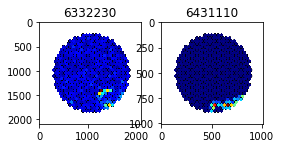

[(81783, 534757, 1)]


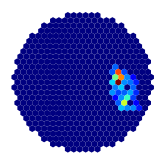

run,evt (81496, 537247)
{'id': 25195, 'image': '81496_ambiguous_evt537247_tel3.jpeg'} 8447 2017-04-02 08:52:17
{'Clean': 'Yes', 'Filename': '81496hide_label_evt537247_tel3.jpeg'} 7872 2017-03-03 23:53:42


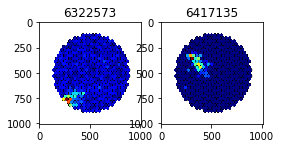

[(81496, 537247, 3)]


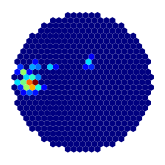

run,evt (81784, 510284)
{'id': 37853, 'image': '81784_ambiguous_evt510284_tel3.jpeg'} 8447 2017-03-27 20:44:01
{'Clean': 'Yes', 'Filename': '81784hide_label_evt510284_tel3.jpeg'} 7872 2017-03-23 04:05:29


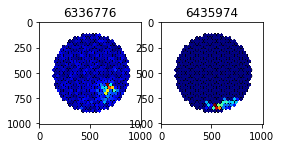

[(81784, 510284, 3)]


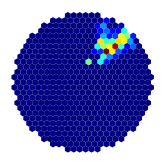

run,evt (78597, 603332)
{'id': 12404, 'image': '78597_ambiguous_evt603332_tel1.jpeg'} 8447 2017-03-05 14:38:37
{'Clean': 'Yes', 'Filename': '78597hide_label_evt603332_tel1.jpeg'} 7872 2017-03-03 23:16:50


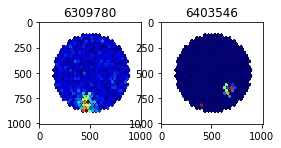

[(78597, 603332, 1)]


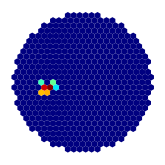

run,evt (78576, 230768)
{'id': 4238, 'image': '78576_ambiguous_evt230768_tel1.jpeg'} 8447 2017-03-08 20:52:57
{'Clean': 'Yes', 'Filename': '78576hide_label_evt230768_tel1.jpeg'} 7872 2017-04-16 04:16:39


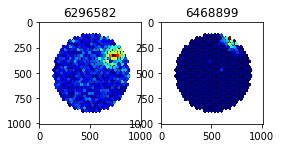

[(78576, 230768, 1)]


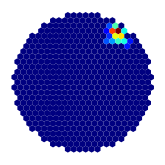

run,evt (78596, 393021)
{'id': 8427, 'image': '78596_ambiguous_evt393021_tel3.jpeg'} 8447 2017-03-14 15:37:51
{'Clean': 'Yes', 'Filename': '78596hide_label_evt393021_tel3.jpeg'} 7872 2017-03-04 14:36:14


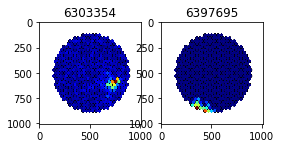

[(78596, 393021, 3)]


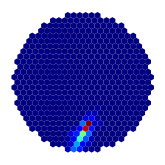

run,evt (81784, 360668)
{'id': 37006, 'image': '81784_ambiguous_evt360668_tel3.jpeg'} 8447 2017-03-09 01:01:00
{'Clean': 'Yes', 'Filename': '81784hide_label_evt360668_tel3.jpeg'} 7872 2017-03-04 10:08:53


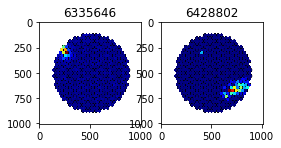

[(81784, 360668, 3)]


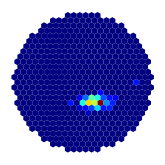

run,evt (78596, 106263)
{'id': 6971, 'image': '78596_ambiguous_evt106263_tel0.jpeg'} 8447 2017-03-21 09:30:37
{'Filename': '78596hide_label_evt106263_tel0.jpeg'} 7872 2017-03-05 14:53:40


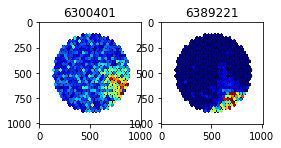

[(78596, 106263, 0)]


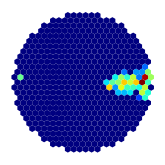

run,evt (81634, 256477)
{'id': 27080, 'image': '81634_ambiguous_evt256477_tel2.jpeg'} 8447 2017-03-14 21:19:15
{'Clean': 'Yes', 'Filename': '81634hide_label_evt256477_tel2.jpeg'} 7872 2017-03-27 06:31:33


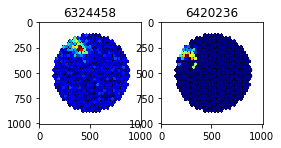

[(81634, 256477, 2)]


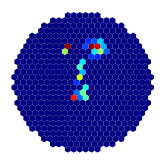

run,evt (78596, 65459)
{'id': 9695, 'image': '78596_ambiguous_evt65459_tel3.jpeg'} 8447 2017-03-14 20:52:57
{'Filename': '78596hide_label_evt65459_tel3.jpeg'} 7872 2017-03-06 11:39:51


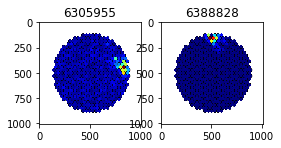

[(78596, 65459, 3)]


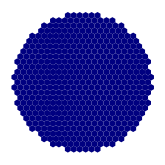

run,evt (81634, 421850)
{'id': 28219, 'image': '81634_ambiguous_evt421850_tel3.jpeg'} 8447 2017-03-22 12:21:05
{'Clean': 'Yes', 'Filename': '81634hide_label_evt421850_tel3.jpeg'} 7872 2017-03-03 19:25:14


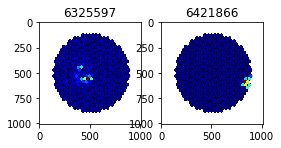

[(81634, 421850, 3)]


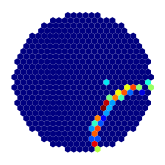

run,evt (81634, 137372)
{'id': 26264, 'image': '81634_ambiguous_evt137372_tel2.jpeg'} 8447 2017-03-12 18:21:45
{'Clean': 'Yes', 'Filename': '81634hide_label_evt137372_tel2.jpeg'} 7872 2017-04-11 20:48:06


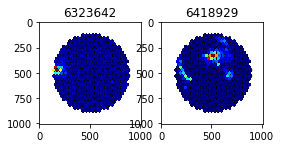

[(81634, 137372, 2)]


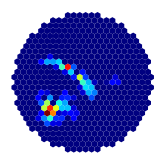

run,evt (78596, 381388)
{'id': 8367, 'image': '78596_ambiguous_evt381388_tel2.jpeg'} 8447 2017-03-26 18:56:52
{'id': 8368, 'image': '78596_ambiguous_evt381388_tel3.jpeg'} 8447 2017-03-11 03:23:21
{'Clean': 'Yes', 'Filename': '78596hide_label_evt381388_tel2.jpeg'} 7872 2017-03-16 14:17:41
{'Clean': 'Yes', 'Filename': '78596hide_label_evt381388_tel3.jpeg'} 7872 2017-03-03 21:18:39


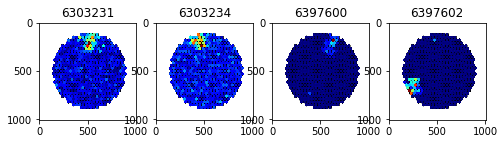

[(78596, 381388, 2)]


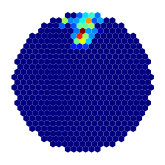

run,evt (81496, 292368)
{'id': 23453, 'image': '81496_ambiguous_evt292368_tel0.jpeg'} 8447 2017-03-04 18:58:52
{'Clean': 'Yes', 'Filename': '81496hide_label_evt292368_tel0.jpeg'} 7872 2017-03-24 21:32:47


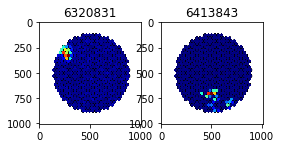

[(81496, 292368, 0)]


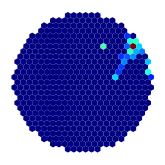

run,evt (78598, 287480)
{'id': 13737, 'image': '78598_ambiguous_evt287480_tel3.jpeg'} 8447 2017-03-04 22:04:38
{'Clean': 'Yes', 'Filename': '78598hide_label_evt287480_tel3.jpeg'} 7872 2017-03-18 15:04:12


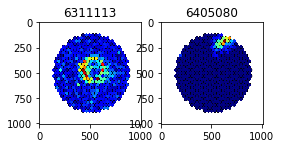

[(78598, 287480, 3)]


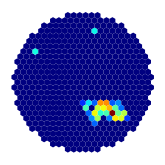

run,evt (78598, 602268)
{'id': 15338, 'image': '78598_ambiguous_evt602268_tel1.jpeg'} 8447 2017-03-10 08:55:27
{'Clean': 'Yes', 'Filename': '78598hide_label_evt602268_tel1.jpeg'} 7872 2017-03-06 13:16:06


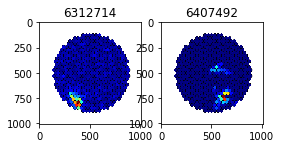

[(78598, 602268, 1)]


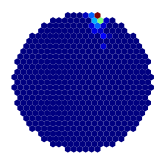

run,evt (81496, 86475)
{'id': 25924, 'image': '81496_ambiguous_evt86475_tel0.jpeg'} 8447 2017-03-16 07:43:53
{'Clean': 'Yes', 'Filename': '81496hide_label_evt86475_tel0.jpeg'} 7872 2017-03-04 05:27:17


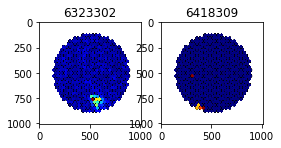

[(81496, 86475, 0)]


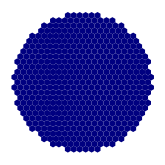

In [37]:
subjects_fname = '/mnt/storage/science_data/muon_data/subjects/subjects.pkl'
import pickle
from muon.utils.subjects import Subjects
with open(subjects_fname, 'rb') as file:
    mh2_subjects = pickle.load(file)

mh2_subjects_mapping = {}
for subject in tqdm(mh2_subjects.iter()):
    run, event, _ = subject.event
    event = run, event
    if event in subjects and len(subjects[event]) >= 1:
        flag = False
        subject_sets = np.array([subject_metadata[s]['subject_set'] for s in subjects[event]])
#         print(np.all(np.isin(subject_sets, [8442, 7872])))
        if np.any(subject_sets == 8447) and np.any(subject_sets == 7872):
#             print(subject_sets)
#         for s in subjects[event]:
#             if int(subject_metadata[s]['subject_set']) in [8447]:
#                 flag = True
#                 break
#         if not flag:
#             continue
            if event not in mh2_subjects_mapping:
                mh2_subjects_mapping[event] = []
            mh2_subjects_mapping[event].append(subject.id)

plot_list = list(mh2_subjects_mapping.keys())
random.shuffle(plot_list)
for event in plot_list[:30]:
    subset = mh2_subjects.subset(mh2_subjects_mapping[event])
    plot_mh1_subjects([event])
    print([subject.event for subject in subset.iter()])
    subset.plot_subjects(w=len(subset))
    plt.show()
    


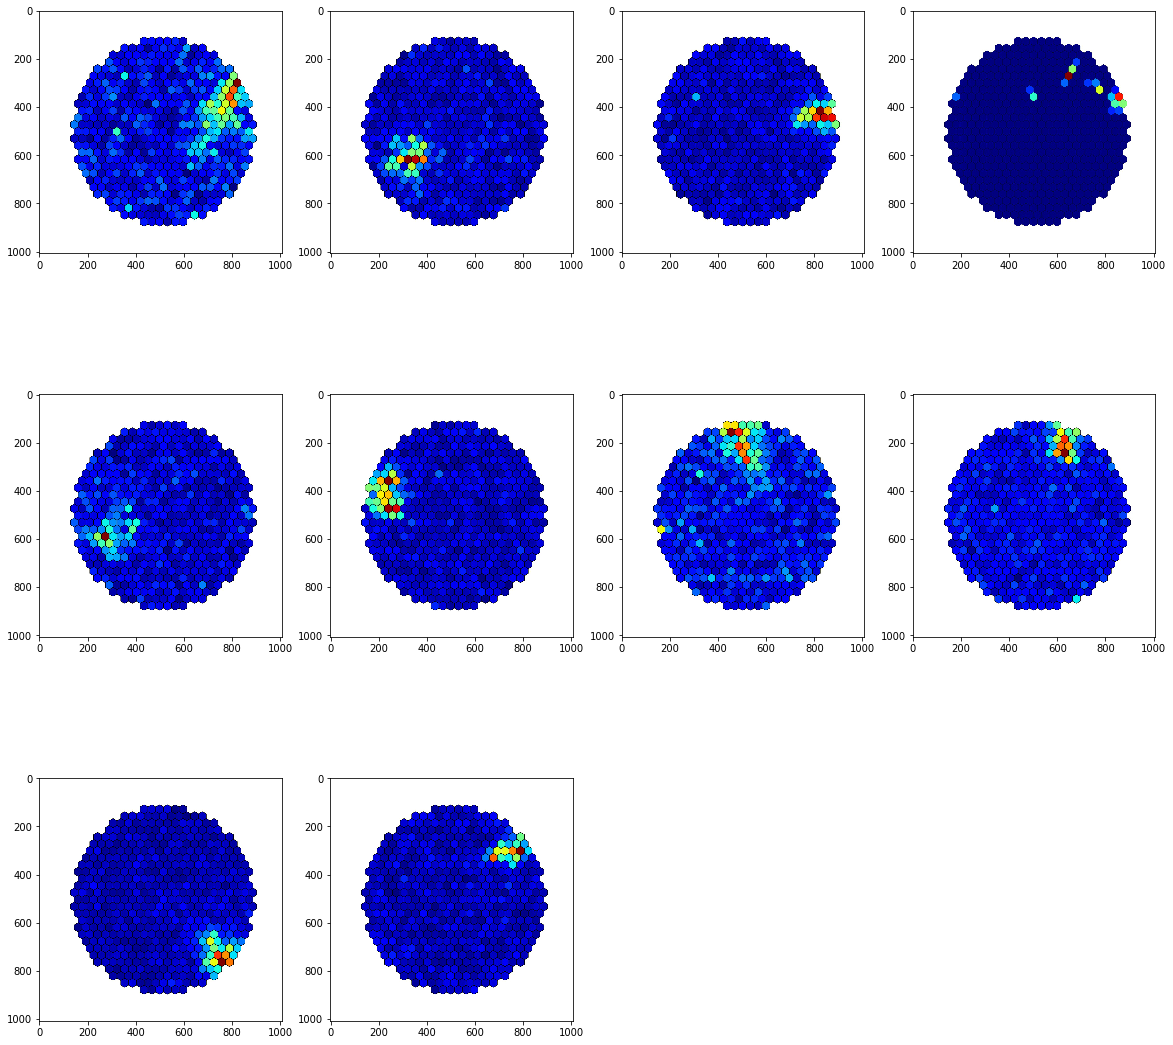

In [37]:
import matplotlib.pyplot as plt
from PIL import Image
# folder = 'muon_hunter_non_muon_images_no_cleaning'

fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(diff):
    folder, fname = fnames[n]
    fname = os.path.join(folder, fname)
    
    ax = fig.add_subplot(3, 4,i+1)
    image = Image.open(fname)
    ax.imshow(image)
plt.show()

In [42]:
import random
images_overlap = random.sample(image_set & subject_set, 100)
print(images_overlap)

[(81783, 180045), (78574, 12073), (81214, 427907), (78573, 195877), (78599, 491541), (78574, 3444), (81783, 39733), (81214, 153387), (78573, 167521), (81634, 2367), (81783, 174420), (78598, 487741), (78574, 21923), (78576, 466341), (81214, 143755), (81783, 8369), (81214, 304288), (78597, 13257), (81783, 408438), (81496, 40114), (78597, 269904), (81214, 15233), (78598, 77868), (81496, 418944), (81634, 644436), (78573, 58951), (81783, 242660), (81784, 167874), (81783, 382227), (78574, 16059), (78574, 11142), (81214, 52941), (78598, 9120), (81634, 604553), (78597, 143339), (81214, 98076), (81635, 45968), (81783, 273794), (81214, 97365), (81634, 566894), (81214, 19162), (81214, 78252), (81214, 644814), (78597, 359389), (78576, 695065), (78599, 9050), (78573, 551070), (78573, 315147), (78597, 97575), (81214, 579172), (81496, 66608), (78596, 223259), (81634, 113051), (81496, 402629), (81214, 23788), (78596, 568), (78598, 80975), (78597, 467291), (81783, 21616), (78598, 13652), (78576, 647269